In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

sys.path.append('..')
file_path = '../data/processed/notebooks/master_analytical_file.parquet'

if os.path.exists(file_path):
    df_master = pd.read_parquet(file_path)
    print(f"Loaded Master Data: {len(df_master):,} rows")
    print(f"Date range: {df_master['shipped_dt'].min()} to {df_master['shipped_dt'].max()}")
else:
    print("Error: Master file not found. Please run Notebook 02 first.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded Master Data: 1,983,549 rows
Date range: 2025-01-01 00:00:00.275000 to 2025-12-31 21:40:11


In [ ]:
# Customer Journey Funnel: Sample to Sale Conversion

funnel_data = df_master.groupby('type')['trade_account_id'].nunique().reset_index()
funnel_data = funnel_data.sort_values('trade_account_id', ascending=False)

fig = px.funnel(
    funnel_data, 
    x='trade_account_id', 
    y='type',
    title='Customer Journey: Sample to Sale Conversion',
    color_discrete_sequence=['#2C3E50', '#E67E22'], 
    labels={'trade_account_id': 'Unique Customers', 'type': 'Stage'}
)

fig.update_traces(textinfo="value+percent initial")
fig.show()

C:\Users\P.Avinash\AppData\Local\Temp\ipykernel_28504\3914566395.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
# Product-Level Conversion: Same Item Sampled vs Sold

sample_pairs = df_master[df_master['type'] == 'SAMPLE'][['trade_account_id', 'item_number']].drop_duplicates()
sale_pairs = df_master[df_master['type'] == 'SALE'][['trade_account_id', 'item_number']].drop_duplicates()
matched_pairs = pd.merge(sample_pairs, sale_pairs, on=['trade_account_id', 'item_number'], how='inner')

matched_funnel_data = pd.DataFrame({
    'Stage': ['Unique Items Sampled', 'Matched Items Sold'],
    'Count': [len(sample_pairs), len(matched_pairs)]
})

fig_matched = px.funnel(
    matched_funnel_data, 
    x='Count', 
    y='Stage',
    title='Product-Level Conversion: Same Item Sampled vs Sold',
    color_discrete_sequence=['#34495E', '#D4AC0D']
)
fig_matched.update_traces(textinfo="value+percent initial")
fig_matched.show()

Average Samples to first Sale: 37.17


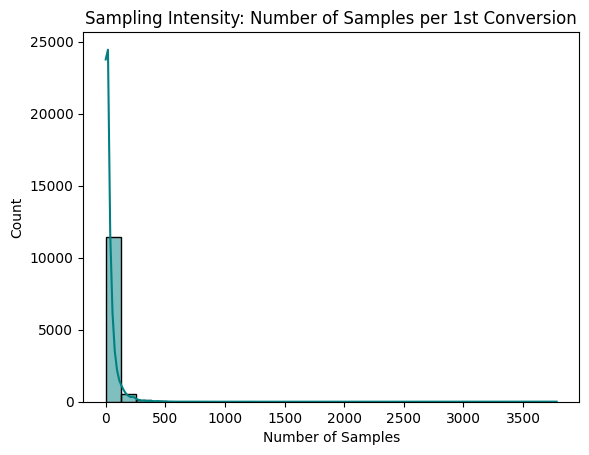

In [ ]:
# Sampling Intensity: Number of Samples before 1st Sale

first_sale = df_master[df_master['type'] == 'SALE'].groupby('trade_account_id')['shipped_dt'].min().reset_index()
first_sale.columns = ['trade_account_id', 'first_sale_date']

pre_sale_samples = df_master[df_master['type'] == 'SAMPLE'].merge(first_sale, on='trade_account_id', how='left')
pre_sale_samples = pre_sale_samples[pre_sale_samples['shipped_dt'] < pre_sale_samples['first_sale_date']]

sampling_intensity = pre_sale_samples.groupby('trade_account_id').size()

print(f"Average Samples to first Sale: {sampling_intensity.mean():.2f}")
sns.histplot(sampling_intensity, bins=30, kde=True, color='teal')
plt.title('Sampling Intensity: Number of Samples per 1st Conversion')
plt.xlabel('Number of Samples')
plt.show()

C:\Users\P.Avinash\AppData\Local\Temp\ipykernel_28504\923750061.py:36: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




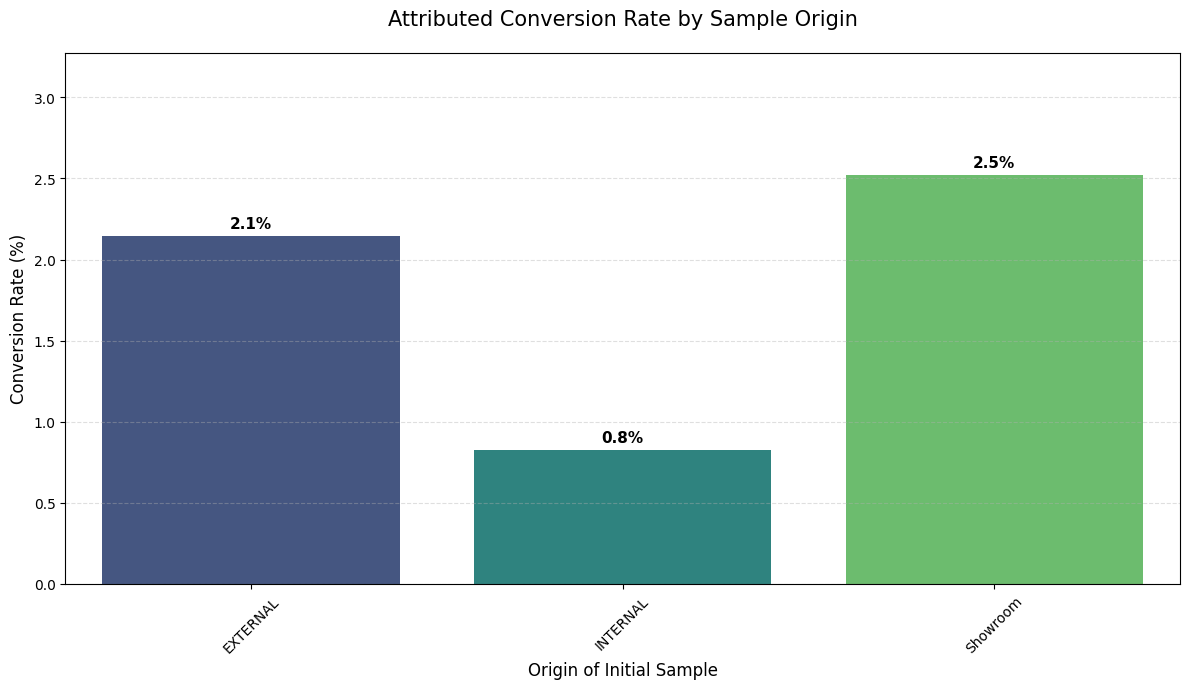

In [ ]:
# Conversion Efficiency by Origin (Channel ROI)
samples = df_master[df_master['type'] == 'SAMPLE'].groupby(['trade_account_id', 'item_number'])['shipped_dt'].min().reset_index()
samples.columns = ['trade_account_id', 'item_number', 'sample_date']

sales = df_master[df_master['type'] == 'SALE'].groupby(['trade_account_id', 'item_number'])['shipped_dt'].min().reset_index()
sales.columns = ['trade_account_id', 'item_number', 'sale_date']

funnel_df = pd.merge(samples, sales, on=['trade_account_id', 'item_number'], how='inner')

funnel_df = funnel_df[funnel_df['sale_date'] >= funnel_df['sample_date']]
funnel_df['days_to_convert'] = (funnel_df['sale_date'] - funnel_df['sample_date']).dt.days

sample_origins = df_master[df_master['type'] == 'SAMPLE'][['trade_account_id', 'item_number', 'origin']].drop_duplicates()

matched_journeys = funnel_df.merge(sample_origins, on=['trade_account_id', 'item_number'], how='left')

total_samples_per_origin = sample_origins['origin'].value_counts()
successful_sales_per_origin = matched_journeys['origin'].value_counts()

origin_stats = pd.DataFrame({
    'SAMPLE': total_samples_per_origin,
    'SALE': successful_sales_per_origin
}).fillna(0)

origin_stats['conversion_rate'] = (origin_stats['SALE'] / origin_stats['SAMPLE']) * 100
origin_stats = origin_stats.sort_values('conversion_rate', ascending=False)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x=origin_stats.index, y=origin_stats['conversion_rate'], palette='viridis')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=11,
                fontweight='bold')

plt.title('Attributed Conversion Rate by Sample Origin', fontsize=15, pad=20)
plt.ylabel('Conversion Rate (%)', fontsize=12)
plt.xlabel('Origin of Initial Sample', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, origin_stats['conversion_rate'].max() * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

C:\Users\P.Avinash\AppData\Local\Temp\ipykernel_28504\893710394.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\P.Avinash\AppData\Local\Temp\ipykernel_28504\893710394.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




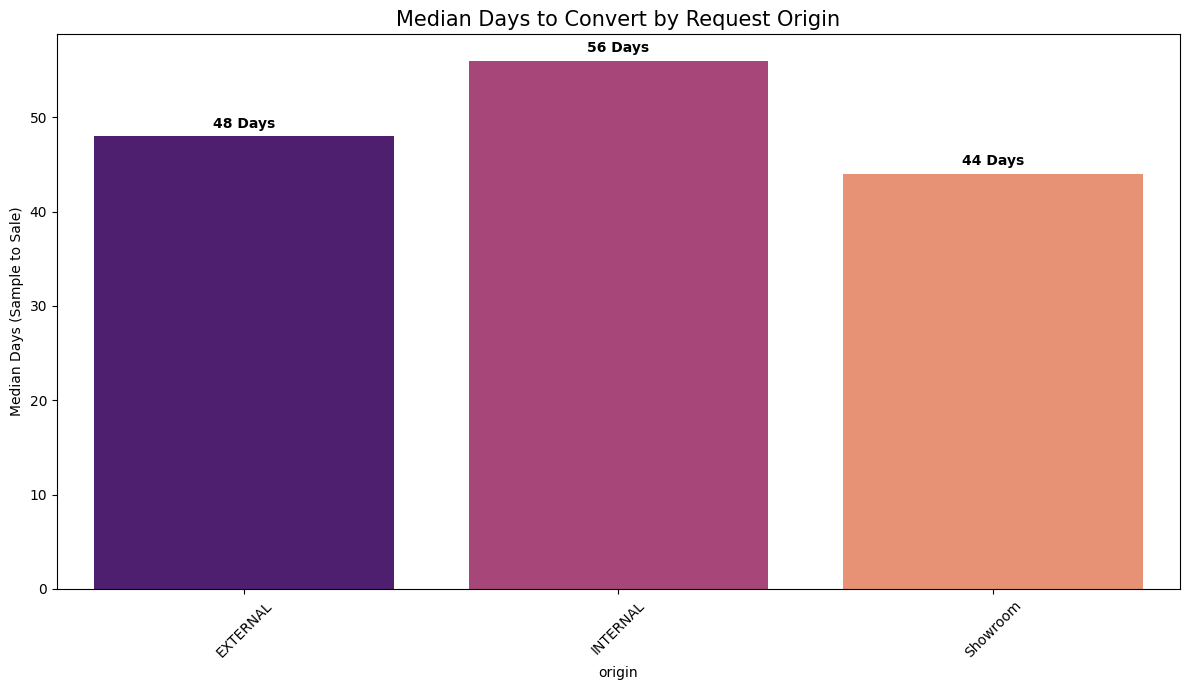

In [22]:
# Time to Convert: Days from Sample to Sale by Origin

origin_map = df_master[df_master['type'] == 'SAMPLE'].drop_duplicates(['trade_account_id', 'item_number'])[['trade_account_id', 'item_number', 'origin']]
velocity_df = funnel_df.merge(origin_map, on=['trade_account_id', 'item_number'], how='left')

origin_velocity = velocity_df.groupby('origin')['days_to_convert'].median().sort_values().reset_index()


plt.figure(figsize=(12, 7))
ax = sns.barplot(x='origin', y='days_to_convert', data=origin_velocity, palette='magma')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)} Days', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontweight='bold')

plt.title('Median Days to Convert by Request Origin', fontsize=15)
plt.ylabel('Median Days (Sample to Sale)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Identifying 'Ghost' Accounts: Sample but Never Buy

all_samplers = set(df_master[df_master['type'] == 'SAMPLE']['trade_account_id'].unique())
all_buyers = set(df_master[df_master['type'] == 'SALE']['trade_account_id'].unique())

ghosts = all_samplers - all_buyers
ghost_rate = (len(ghosts) / len(all_samplers)) * 100

print(f"Total Samplers: {len(all_samplers):,}")
print(f"Total 'Ghost' Accounts (Sample but never Buy): {len(ghosts):,}")
print(f"Ghost Rate: {ghost_rate:.2f}%")

plt.pie([len(all_samplers)-len(ghosts), len(ghosts)], 
        labels=['Converted Accounts', 'Ghost Accounts'], 
        autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'], startangle=140)
plt.title('Account Engagement: Conversion vs. Ghosting')
plt.show()